<a href="https://colab.research.google.com/github/marquinamaria/UCB_MDSv4_ML/blob/main/Proyecto%20Final/Proyecto_Final%20-%20NLP%20Attention%20is%20all%20you%20need/MDSv4_ML_PFinal_NLP_Attention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP con Transformers

### Integrantes
* Maria Ines Marquina Guevara

## Descripcion del Problema

Traduccion de texto en espaniol al ingles, usando la arquitectura propuesta en
[Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) de Vaswani et al. (2017).

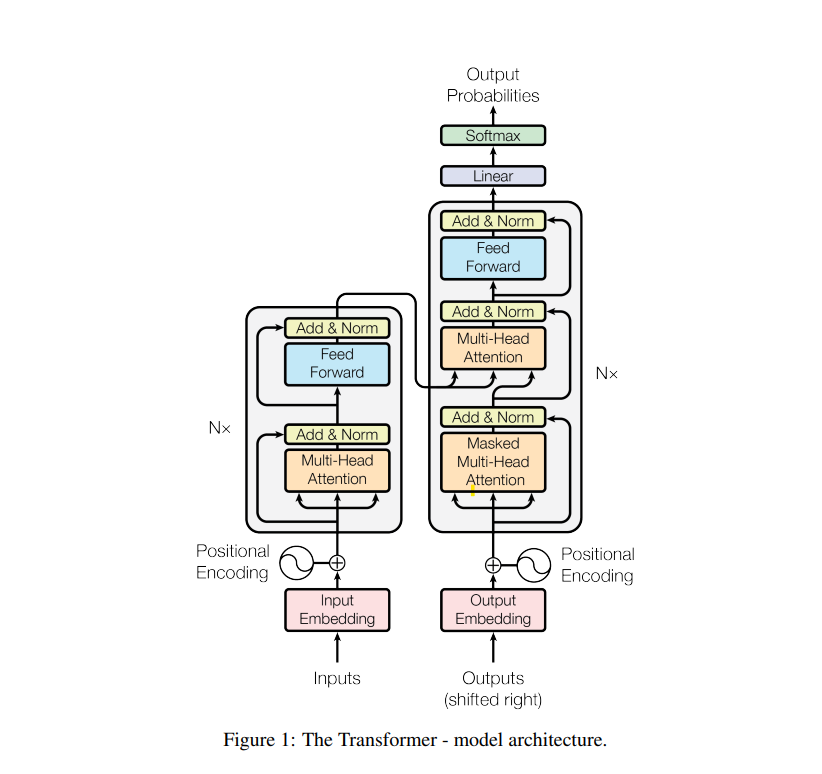


## Setup e Importacion de Librerias

In [ ]:
!pip install -U nltk 'gensim==4.2.0' 'keras-nlp' 'keras-preprocessing' 'tensorflow-text>2.11'

In [ ]:
import multiprocessing
import tensorflow as tf
import sys

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras import preprocessing
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model, Input
import tensorflow_text as tf_text
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import time

In [ ]:
TRACE = False

def set_seeds_and_trace():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)
    if TRACE:
        tf.debugging.set_log_device_placement(True)

def set_session_with_multiple_gpus_and_cores():
    cores = multiprocessing.cpu_count()
    gpus = len(tf.config.list_physical_devices('GPU'))
    config = tf.compat.v1.ConfigProto(device_count={'GPU': gpus, 'CPU': cores})
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)

In [ ]:
set_seeds_and_trace()
set_session_with_multiple_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Las capas del Transformer

### Positional Encoding

Implementamos el algoritmo explicado en el paper *3.5 Positional Encoding*

In [ ]:
from tensorflow._api.v2.compat.v1 import newaxis

def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth

    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)


In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [ ]:
positional_embedding = PositionalEmbedding(5000, 100)

Creamos un input de 3 sentencias y 26 palabras

In [ ]:
input = tf.constant(np.random.randint(1, 5000, size=(3, 26)))

In [ ]:
response = positional_embedding(input)
response.shape
# 100 es el embedding dimension

TensorShape([3, 26, 100])

In [ ]:
response._keras_mask

<tf.Tensor: shape=(3, 26), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True]])>

### Self Attention Layer

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layer_normalization = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [ ]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attention_output = self.multi_head_attention(
            query = x,
            value = x,
            key = x
        )
        x = self.add([x, attention_output])
        x = self.layer_normalization(x)
        return x

In [ ]:
embedding_dimension = 100
vocabulary_size = 5000
input = tf.constant(np.random.randint(1, vocabulary_size, size=(3, 6)))

pos = PositionalEmbedding(vocabulary_size, embedding_dimension)
gsa = GlobalSelfAttention(num_heads=3, key_dim=embedding_dimension)
response = gsa(pos(input))
response.shape

TensorShape([3, 6, 100])

### Cross Attention Layer

Conecta el encoder con el decoder

* **x** es el target
* **context** es el valor que retorno el Encoder


In [ ]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attention_output, attention_scores = self.multi_head_attention(
            query = x,
            value = context,
            key = context,
            return_attention_scores=True)

        self.last_attention_scores = attention_scores
        x = self.add([x, attention_output])
        x = self.layer_normalization(x)
        return x


In [ ]:
embedding_dimension_spanish = 100
vocabulary_size_spanish = 5000

embedding_dimension_english = 512
vocabulary_size_english = 6000

input_spanish = tf.constant(np.random.randint(1, vocabulary_size_spanish, size=(3, 26)))
input_english = tf.constant(np.random.randint(1, vocabulary_size_english, size=(3, 24)))

pos_spanish = PositionalEmbedding(vocabulary_size_spanish, embedding_dimension_spanish)
pos_english = PositionalEmbedding(vocabulary_size_english, embedding_dimension_english)

gsa = GlobalSelfAttention(num_heads=3, key_dim=embedding_dimension_spanish)
cross = CrossAttention(num_heads=3, key_dim=embedding_dimension_english)

context = gsa(pos_spanish(input_spanish))
response = cross(pos_english(input_english), context=context)
response.shape

TensorShape([3, 24, 512])

### Multi Headed Attention Layer

* **use_casual_mask** indica que no podemos ver hacia el futuro es decir la Nth palabra soslo puede ver N-1  palabras y no toda la oracion

In [ ]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attention_output = self.multi_head_attention(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True)
        x = self.add([x, attention_output])
        x = self.layer_normalization(x)
        return x

In [ ]:
embedding_dimension_english = 512
vocabulary_size_english = 6000

input_english = tf.constant(np.random.randint(1, vocabulary_size_spanish, size=(3, 24)))
pos_english = PositionalEmbedding(vocabulary_size_english, embedding_dimension_english)

csa = CausalSelfAttention(num_heads=3, key_dim=embedding_dimension_english)
response = csa(pos_spanish(input_english))
response.shape

TensorShape([3, 24, 100])

### Feed Forward Network

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x


### Encoder Layer

La capa del **Encoder** contiene un stack de N capas, cada **EncoderLayer** contiene las siguientes capas: un **GlobalSelfttention** y un **FeedForward**

In [ ]:
from keras.api._v1.keras.backend import dropout
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.fnn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.fnn(x)
        return x

In [ ]:
embedding_dimession = 100
vocabulary_size = 5000

input = tf.constant(np.random.randint(1, vocabulary_size, size=(3, 26)))
pos = PositionalEmbedding(vocabulary_size, embedding_dimension)
sample_encoder_layer = EncoderLayer(d_model=embedding_dimension, num_heads=3, dff=1012)
response = sample_encoder_layer(pos(input))
response.shape

TensorShape([3, 26, 100])

### El Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x

In [ ]:
embedding_dim = 100
vocab_size = 5000
input = tf.constant(np.random.randint(1, vocab_size, size=(3, 24)))

sample_encoder = Encoder(num_layers=4,
                         d_model=embedding_dim,
                         num_heads=3,
                         dff=512,
                         vocab_size=vocab_size)
response = sample_encoder(input)
response.shape

TensorShape([3, 24, 100])

### Decoder Layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        self.last_attention_scores = self.cross_attention.last_attention_scores
        x = self.ffn(x)
        return x

In [ ]:
embedding_dim_spanish = 100
vocab_size_spanish = 5000

embedding_dim_english = 512
vocab_size_english = 6000

input_spanish = tf.constant(np.random.randint(1, vocab_size_spanish, size=(3, 26)))
input_english = tf.constant(np.random.randint(1, vocab_size_english, size=(3, 24)))

pos_english = PositionalEmbedding(vocab_size_english, embedding_dim_english)

encoder = Encoder(num_layers=2, d_model=embedding_dim_spanish, num_heads=3, dff=512, vocab_size=vocab_size_spanish)
context = encoder(input_spanish)

decoder_layer = DecoderLayer(d_model=embedding_dim_english, num_heads=3, dff=218, dropout_rate=0.2)
response = decoder_layer(pos_english(input_english), context=context)
response.shape

TensorShape([3, 24, 512])

### El Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, x, context):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)
        self.last_attention_scores = self.dec_layers[-1].last_attention_scores
        return x

    # def get_initial_state(self, context):
    #     batch_size = tf.shape(context)[0]
    #     start_tokens = tf.fill([batch_size, 1], '[START]')
    #     done = tf.zeros([batch_size, 1], dtype=tf.bool)
    #     embedded = self.pos_embedding (start_tokens)
    #     return start_tokens, done, self.pos_embedding(embedded)[0]

    # def tokens_to_text(self, tokens):
    #     words = self.id

In [ ]:
embedding_dim_spanish = 100
vocab_size_spanish = 5000

embedding_dim_english = 512
vocab_size_english = 6000

input_spanish = tf.constant(np.random.randint(1, vocab_size_spanish, size=(3, 26)))
input_english = tf.constant(np.random.randint(1, vocab_size_english, size=(3, 24)))

pos_english = PositionalEmbedding(vocab_size_english, embedding_dim_english)

encoder = Encoder(num_layers=2, d_model=embedding_dim_spanish, num_heads=3, dff=512, vocab_size=vocab_size_spanish)
context = encoder(input_spanish)

decoder = Decoder(num_layers=3, d_model=embedding_dim_english, num_heads=5, dff=124, vocab_size=vocab_size_english)
response = decoder(input_english, context=context)

response.shape

TensorShape([3, 24, 512])

## El Transformer Model

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               d_model=d_model,
                               num_heads=num_heads,
                               dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers,
                               d_model=d_model,
                               num_heads=num_heads,
                               dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        x = self.decoder(x, context)

        # Linear Layer output that has the final output and the attention weights
        logits = self.final_layer(x)
        return logits

In [ ]:
embedding_dim = 100
vocab_size_spanish = 5000
vocab_size_english = 6000

num_layers = 4
dff = 512 # dimension of the fully connected layer
num_heads = 8
dropout_rate = 0.1

In [ ]:
input_spanish = tf.constant(np.random.randint(1, vocab_size_spanish, size=(3, 26)))
input_spanish

<tf.Tensor: shape=(3, 26), dtype=int64, numpy=
array([[2262, 2287, 4203, 2879, 4144, 3645, 4433, 2056, 4721, 1277, 2767,
         303,  639,   56, 4822,  526, 4570, 4124, 2126, 3288,  365, 4622,
        4979, 1647,  919, 2798],
       [1532, 3346, 1907, 3087, 4581, 2076,  714, 1063, 1977, 1297,  126,
        4633, 3597, 3284, 1604,   67,  233, 2157, 1170, 2159, 4207, 1494,
        4719, 4008, 2473, 2661],
       [2740, 1762, 3515, 1976, 2363,  877, 3813, 3449, 1313, 1461, 2710,
        2325, 1734, 1606, 2564, 3422, 3518, 2398, 3736, 2871, 1161, 4855,
         243, 2591, 1064, 4325]])>

In [ ]:
input_english = tf.constant(np.random.randint(1, vocab_size_english, size=(3, 24)))
input_english

<tf.Tensor: shape=(3, 24), dtype=int64, numpy=
array([[2596,  920, 5343,    6,  468, 5852, 4171,    4, 5967,  646,  118,
        2929, 5726, 2552, 5043, 5561, 4290,  847, 2763, 5512, 5555, 5765,
        5530, 1142],
       [1811,  724,  225, 4628, 4209, 4655, 2049, 4750, 4416, 1574, 1829,
        1918, 4235, 2027, 3745,  902, 4786, 2040,   10,  261, 1674, 2220,
        2061, 5288],
       [3714, 1620,  321, 1343, 5733, 2377, 2833, 2825, 1995, 2959, 2039,
        3491, 3678, 1119, 1605, 4028,  236, 1970, 4430, 1909,  376, 3531,
        5257, 2636]])>

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=embedding_dim,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size_spanish,
    target_vocab_size=vocab_size_english,
    dropout_rate=dropout_rate
)

response = transformer((input_spanish, input_english))
response.shape

TensorShape([3, 24, 6000])

In [ ]:
transformer.summary()

Model: "transformer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_13 (Encoder)        multiple                  2203648   
                                                                 
 decoder_7 (Decoder)         multiple                  3594448   
                                                                 
 dense_162 (Dense)           multiple                  606000    
                                                                 
Total params: 6404096 (24.43 MB)
Trainable params: 6404096 (24.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Cargamos un dataset y entrenamos el Transformer

In [ ]:
def load_data(path):
    text = path.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    context = np.array([context for _, context in pairs])
    target = np.array([target for target, _ in pairs])
    return target, context

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib
path = pathlib.Path("/content/drive/My Drive/Colab Notebooks/P3_Proyecto/_data/spa.txt")
target_raw, context_raw = load_data(path)

In [ ]:
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [ ]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Construimos el tensorflow dataset

In [ ]:
buffer_size = len(context_raw)
batch_size = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

# training
train_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(buffer_size)
    .batch(batch_size)
)

# validation
val_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(buffer_size)
    .batch(batch_size)
)

Tomamos un ejemplar de **train_row** para explorar el **context** y el **target**

In [ ]:
example_context_strings = None
example_target_strings = None
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings)
    print()
    print(example_target_strings)
    break

tf.Tensor(
[b'No puedo ver bien el escenario desde este asiento.'
 b'\xc2\xbfMe ayudar\xc3\xa1s?' b'Tom se sac\xc3\xb3 los zapatos.'
 b'\xc2\xbfHa le\xc3\xaddo los cl\xc3\xa1sicos latinos?'
 b'Tom est\xc3\xa1 un poco ocupado, y no puede ayudarte hoy.'
 b'No creas que no me gustas.' b'Once estudiantes recibieron el premio.'
 b'Est\xc3\xa1bamos apunto de salir cuando son\xc3\xb3 el tel\xc3\xa9fono.'
 b'Ella me pregunt\xc3\xb3 cu\xc3\xa1ntas lenguas hablaba.'
 b'Tom se preocupa demasiado.'
 b'Es importante que elijamos buenos amigos.'
 b'Hoy no tienes que trabajar.'
 b'El beb\xc3\xa9 est\xc3\xa1 durmiendo en la cuna.'
 b'\xc3\x89l me agarr\xc3\xb3 por la mu\xc3\xb1eca.'
 b'\xc2\xbfEst\xc3\xa1s ocupado todav\xc3\xada?' b'Tom estaba en coma.'
 b'Las manzanas son rojas o verdes.'
 b'Evito cruzar la calle por aqu\xc3\xad si estoy apurado.'
 b'Dos contra uno no es pelea justa.'
 b'Encontr\xc3\xa9 a Tom despu\xc3\xa9s del trabajo.'
 b'Mi cu\xc3\xb1ado es polic\xc3\xada.' b'Tengo que hacerlo aho

### Text processing

Necesitamos procesar el text para remover caracteres con acentos, espacios en blanco, etc

In [ ]:
example_text = tf.constant('Tendré que revisar mi agenda.')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Tendr\xc3\xa9 que revisar mi agenda.'
b'Tendre\xcc\x81 que revisar mi agenda.'


In [ ]:
def process_with_tf_strings(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return  text

In [ ]:
print(example_text.numpy().decode())
print(process_with_tf_strings(example_text).numpy().decode())

Tendré que revisar mi agenda.
[START] tendre que revisar mi agenda . [END]


### Text Vectorization

Pasamos de Natural Language a Ids

In [ ]:
max_vocab_size = 50000
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=process_with_tf_strings,
    max_tokens=max_vocab_size,
    ragged=True
)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [ ]:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

Hacemos el mismo procedimiento con los **targets**

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=process_with_tf_strings,
    max_tokens=max_vocab_size,
    ragged=True
)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 13, 21, 5, 30, 3382, 6, 25, 368, 33, 9, 46, 486, 12, 3],
 [2, 7, 752, 15, 37, 144, 22, 5, 7, 209, 37, 1811, 4, 3],
 [2, 9, 18, 12752, 162, 83, 3]]>

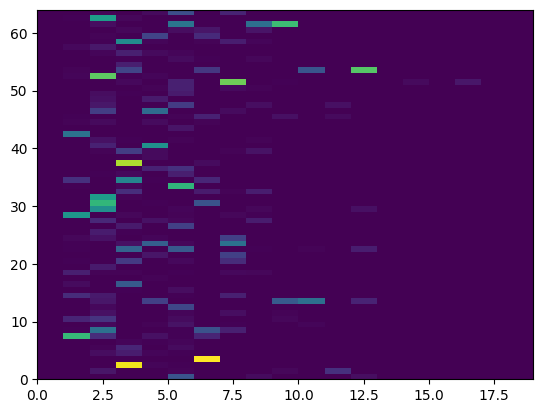

In [ ]:
plt.pcolormesh(example_tokens.to_tensor())

### Procesamos el dataset

* Los inputs son el (context, target_in) y los labels son el target_out. La diferencia entre target_in y target_out es que estan desplazados por un paso relativo al otro de forma que cada ubicacion del label es el siguiente token

* Generamos los datasets de **training** y **validacion**

In [ ]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    target_in = target[:, :-1].to_tensor()
    target_out = target[:, 1:].to_tensor()
    return (context, target_in), target_out

In [ ]:
train_dataset = train_raw.map(process_text, tf.data.AUTOTUNE)
validation_dataset = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_token, ex_target_in), ex_target_out in train_dataset.take(1):
    print(ex_context_token[0:, :10].numpy())
    print()
    print(ex_target_in[0:, :10].numpy())
    print(ex_target_out[0:, :10].numpy())

[[    2    13    72   452     7  2077    12     3     0     0]
 [    2    49   389 20890    33   500  1004     4     3     0]
 [    2    39  1079    56     7    84     4     3     0     0]
 [    2     7   150  1748    16   108     6   209    33    17]
 [    2    48   382    23   210  2250     4     3     0     0]
 [    2    57    15  2442     4     3     0     0     0     0]
 [    2   668   125   864     4     3     0     0     0     0]
 [    2    24   697    18   531    37   517     4     3     0]
 [    2   395    16   208   218     5   344     4     3     0]
 [    2    92    17   452     4     3     0     0     0     0]
 [    2   169  6705     8    34  3620     6    11  2415     4]
 [    2    10     9   250  6359    46    56    11  1679     6]
 [    2   712     5  8917     7   598   145     5    39  1409]
 [    2     9    49     8   112     5  2273  1074     8    24]
 [    2    10    20    14    25   463    19   248    23  1547]
 [    2    67 16751   811     4     3     0     0     0

### Entrenamos el Transformer

In [ ]:
embedding_dim = 100
vocab_size_spanish = context_text_processor.vocabulary_size()
vocab_size_english = target_text_processor.vocabulary_size()

print("vocab_size_spanish", vocab_size_spanish)
print("vocab_size_english", vocab_size_english)

num_layers = 4
dff = 512 # dimension of the fully connected layer
num_heads = 8
dropout_rate = 0.1

vocab_size_spanish 22661
vocab_size_english 12393


In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=embedding_dim,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size_spanish,
    target_vocab_size=vocab_size_english,
    dropout_rate=dropout_rate
)

In [ ]:
response = transformer((context_text_processor(example_context_strings).to_tensor(), target_text_processor(example_target_strings).to_tensor()))
response.shape

TensorShape([64, 21, 12393])

In [ ]:
transformer.summary()

Model: "transformer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_14 (Encoder)        multiple                  3969748   
                                                                 
 decoder_8 (Decoder)         multiple                  4233748   
                                                                 
 dense_179 (Dense)           multiple                  1251693   
                                                                 
Total params: 9455189 (36.07 MB)
Trainable params: 9455189 (36.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Entrenamos el Transformer

In [ ]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )
    loss = loss_fn(y_true, y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [ ]:
transformer.compile(optimizer='adam', loss=masked_loss, metrics=[masked_accuracy, masked_loss])

In [ ]:
history = transformer.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch = 100,
    validation_data=validation_dataset,
    validation_steps=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)
    ])

Epoch 1/10
100/100 [==============================] - 327s 3s/step - loss: 6.0872 - masked_accuracy: 0.2008 - masked_loss: 6.0860 - val_loss: 4.9299 - val_masked_accuracy: 0.2502 - val_masked_loss: 4.9310
Epoch 2/10
100/100 [==============================] - 279s 3s/step - loss: 4.6343 - masked_accuracy: 0.2838 - masked_loss: 4.6345 - val_loss: 4.3862 - val_masked_accuracy: 0.2999 - val_masked_loss: 4.3873
Epoch 3/10
100/100 [==============================] - 298s 3s/step - loss: 4.3497 - masked_accuracy: 0.3085 - masked_loss: 4.3518 - val_loss: 4.2373 - val_masked_accuracy: 0.3222 - val_masked_loss: 4.2393
Epoch 4/10
100/100 [==============================] - 268s 3s/step - loss: 4.1312 - masked_accuracy: 0.3255 - masked_loss: 4.1327 - val_loss: 4.0396 - val_masked_accuracy: 0.3270 - val_masked_loss: 4.0400
Epoch 5/10
100/100 [==============================] - 283s 3s/step - loss: 4.0563 - masked_accuracy: 0.3310 - masked_loss: 4.0585 - val_loss: 3.9626 - val_masked_accuracy: 0.3375 -

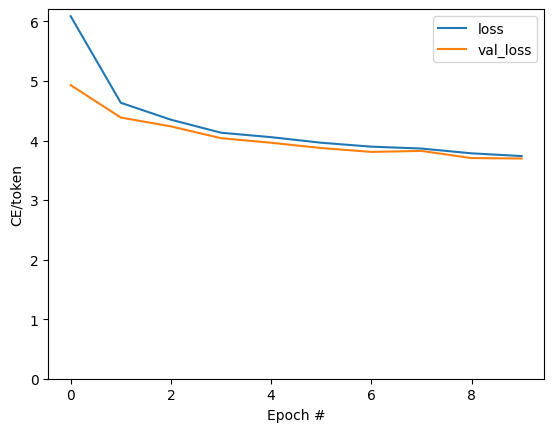

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

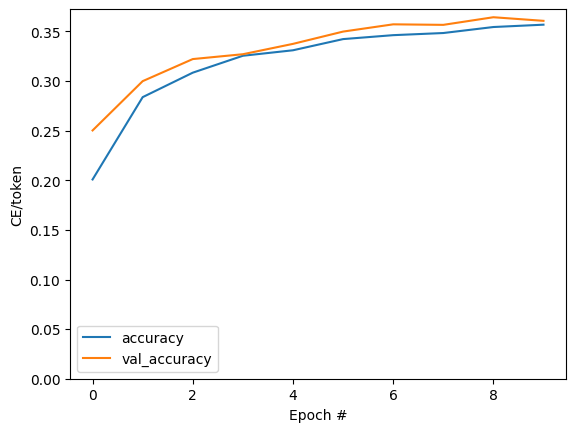

In [ ]:
plt.plot(history.history['masked_accuracy'], label='accuracy')
plt.plot(history.history['val_masked_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## El Translator

In [ ]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=100000):
        # The input sentence is spanish, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]
            sentence = tf.convert_to_tensor(sentence)[tf.newaxis]

        sentence = self.tokenizers["es"]([sentence]).to_tensor()
        encoder_input = sentence
        print('encoder_input', encoder_input)

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        start_end = self.tokenizers["en"]([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())

        id_to_word = tf.keras.layers.StringLookup(
            vocabulary=self.tokenizers["en"].get_vocabulary(),
            mask_token='',
            oov_token='[UNK]',
            invert=True
        )

        words = id_to_word(output)

        text = tf.strings.reduce_join(words, axis=-1, separator=' ')
        text = tf.strings.regex_replace(text, '^ *\[START\] *', '')
        text = tf.strings.regex_replace(text, ' *\[END\] *$', '')


        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attention_scores

        return text[0], words, attention_weights

In [ ]:
translator = Translator(
    {"es": context_text_processor, "en":target_text_processor}, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "Tendré que revisar mi agenda."
ground_truth = "I'll need to check my schedule."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant([sentence]))

print_translation(sentence, translated_text, ground_truth)

encoder_input tf.Tensor([[   2 1515    5 4735   24 5722    4    3]], shape=(1, 8), dtype=int64)
Input:         : Tendré que revisar mi agenda.
Prediction     : i have a good idea .
Ground truth   : I'll need to check my schedule.


In [ ]:
attention_weights.shape

TensorShape([1, 8, 7, 8])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = process_with_tf_strings(in_tokens)
in_tokens = tf.strings.split(in_tokens, sep=' ').to_tensor()
in_tokens[0]

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'[START]', b'tendre', b'que', b'revisar', b'mi', b'agenda', b'.',
       b'[END]'], dtype=object)>

In [ ]:
translated_tokens[0]

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'[START]', b'i', b'have', b'a', b'good', b'idea', b'.', b'[END]'],
      dtype=object)>

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([7, 8])

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

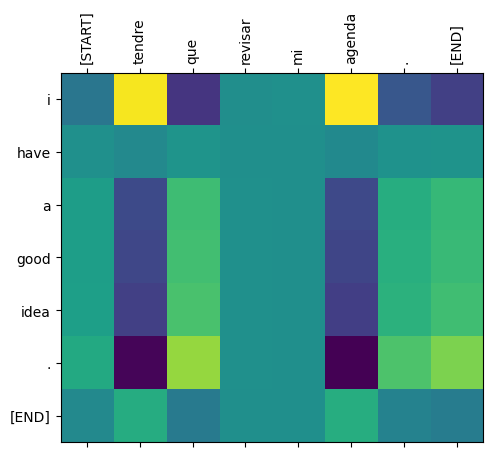

In [ ]:
plot_attention_head(in_tokens[0], translated_tokens[0], attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = process_with_tf_strings(in_tokens)
    in_tokens = tf.strings.split(in_tokens, sep=' ').to_tensor()[0]
    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

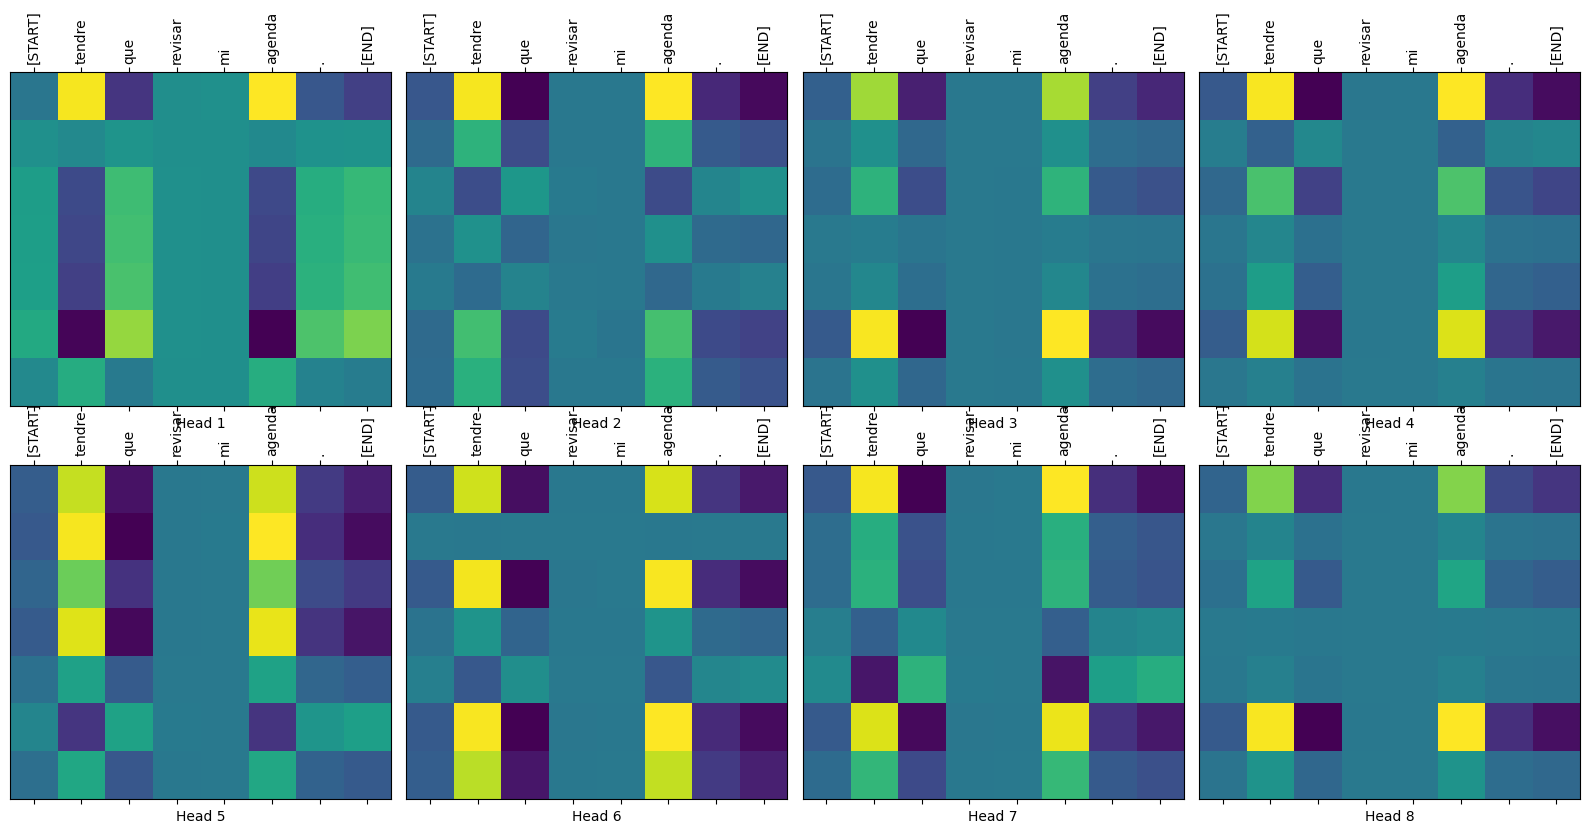

In [ ]:
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

encoder_input tf.Tensor([[   2 1717    8   10    4    3]], shape=(1, 6), dtype=int64)
Input:         : Pregúntale a Tom.
Prediction     : i have a lot of time .
Ground truth   : Ask Tom.


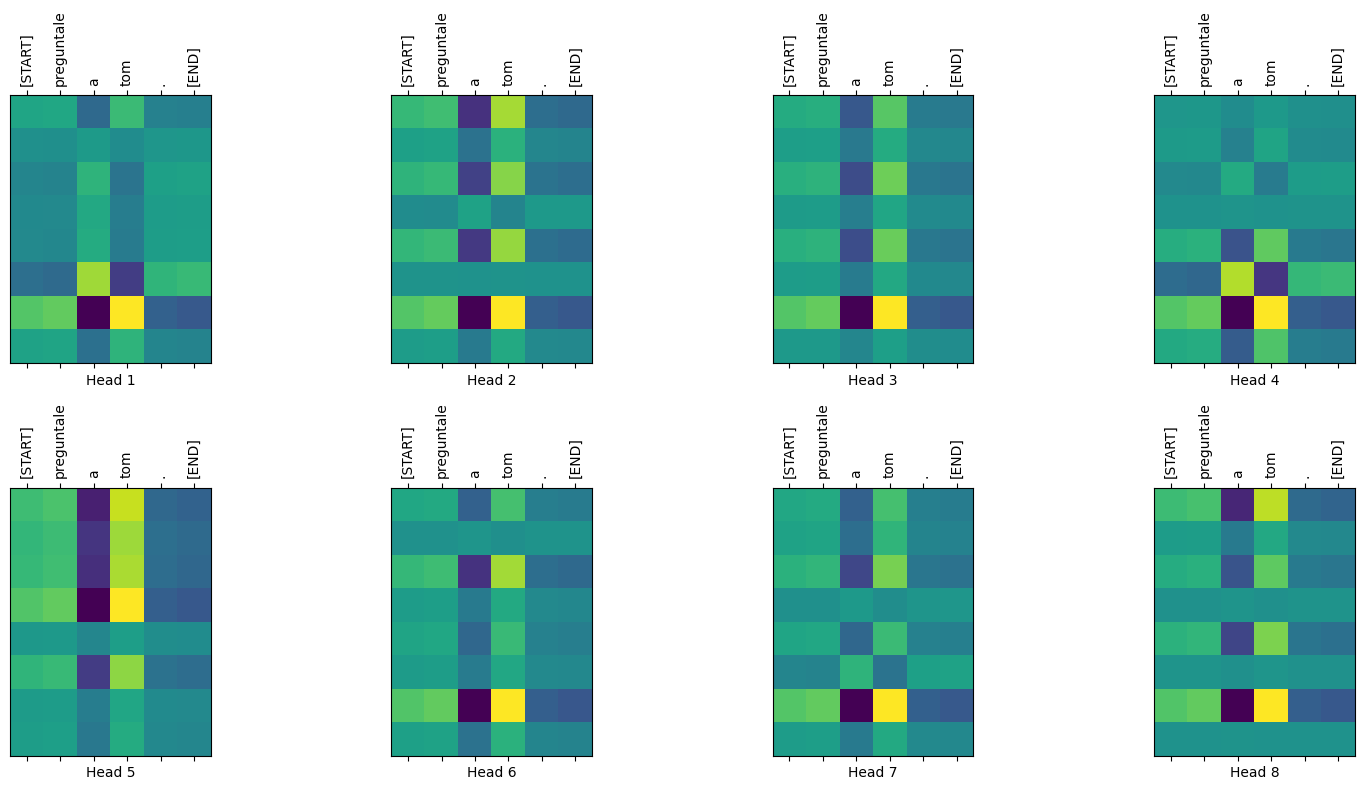

In [ ]:
sentence = 'Pregúntale a Tom.'
ground_truth = 'Ask Tom.'

translated_text, translated_tokens, attention_weights = translator(tf.constant([sentence]))
print_translation(sentence, translated_text, ground_truth)
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

encoder_input tf.Tensor([[  2  13 310  68  12   3]], shape=(1, 6), dtype=int64)
Input:         : ¿Podemos ir?
Prediction     : i have a lot of time .
Ground truth   : Can we go?


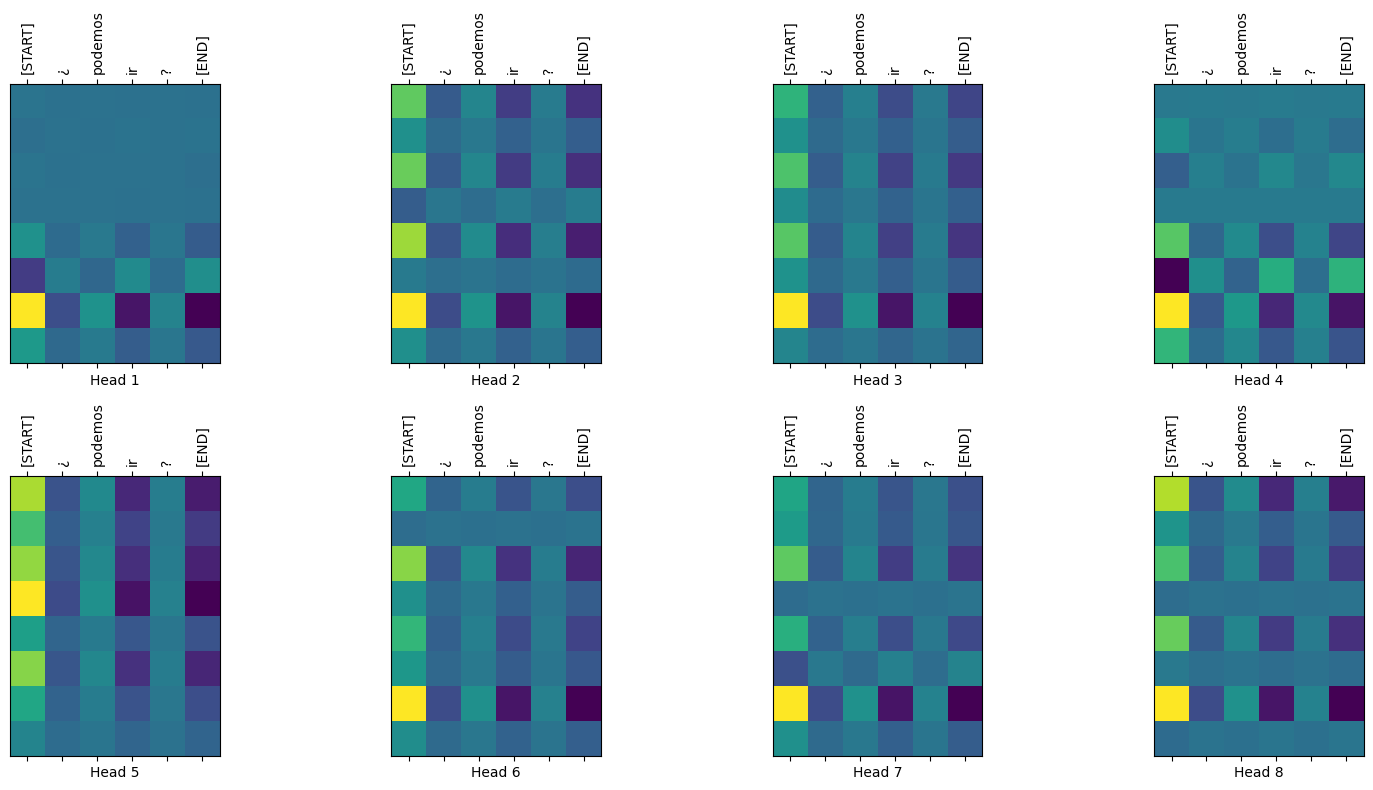

In [ ]:
sentence = '¿Podemos ir?'
ground_truth = 'Can we go?'

translated_text, translated_tokens, attention_weights = translator(tf.constant([sentence]))
print_translation(sentence, translated_text, ground_truth)
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

encoder_input tf.Tensor([[   2 2047    4    3]], shape=(1, 4), dtype=int64)
Input:         : Hola.
Prediction     : i have a lot .
Ground truth   : Hi.


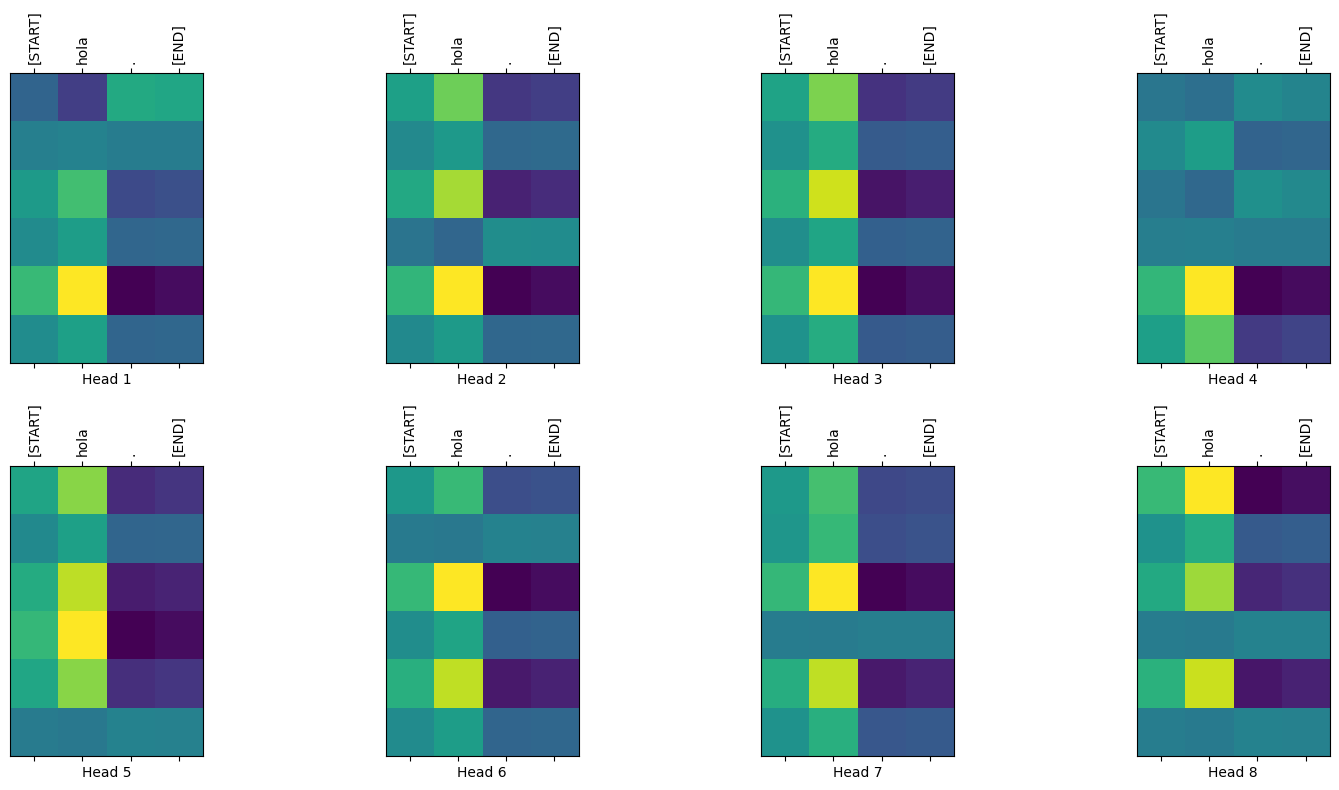

In [ ]:
sentence = 'Hola.'
ground_truth = 'Hi.'

translated_text, translated_tokens, attention_weights = translator(tf.constant([sentence]))
print_translation(sentence, translated_text, ground_truth)
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

encoder_input tf.Tensor([[   2 1149    4    3]], shape=(1, 4), dtype=int64)
Input:         : Escucha.
Prediction     : i have a lot .
Ground truth   : Listen.


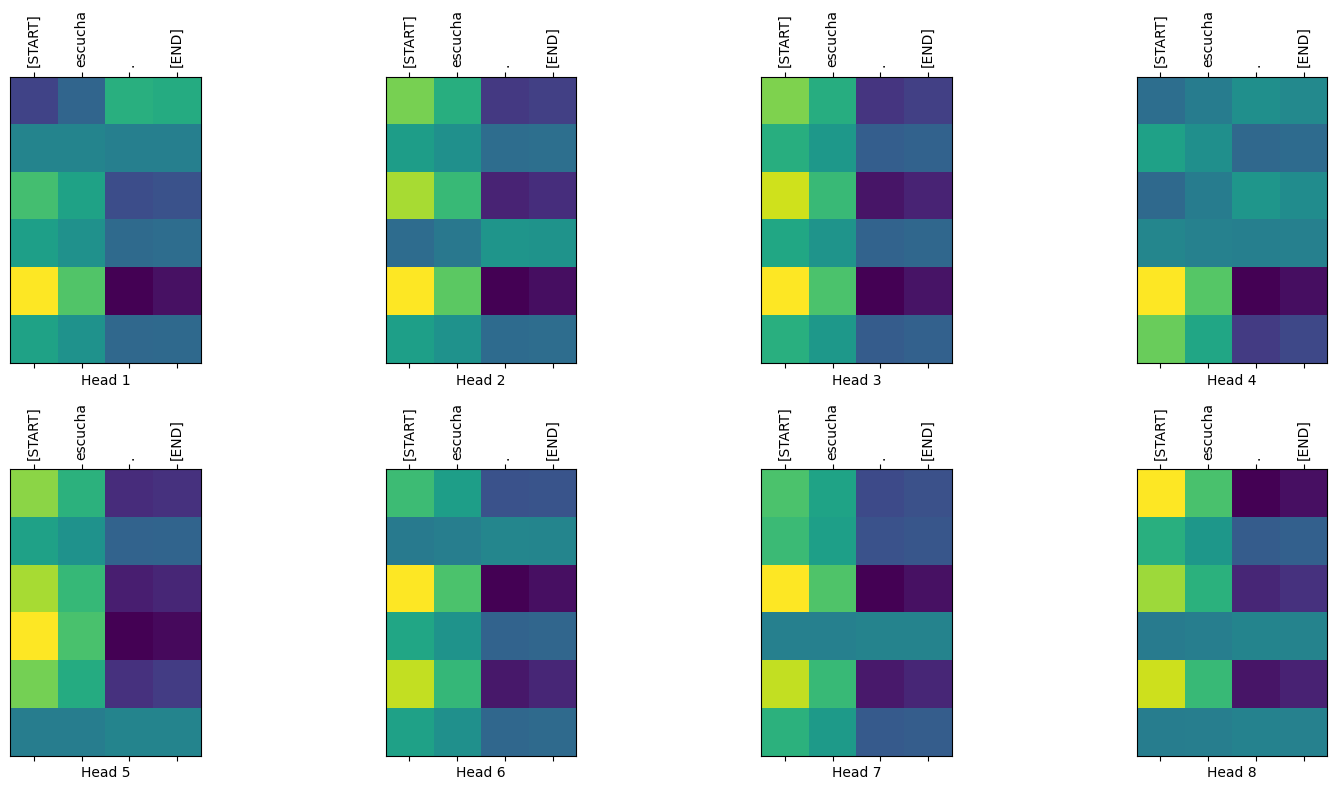

In [ ]:
sentence = 'Escucha.'
ground_truth = 'Listen.'

translated_text, translated_tokens, attention_weights = translator(tf.constant([sentence]))
print_translation(sentence, translated_text, ground_truth)
plot_attention_weights(sentence, translated_tokens, attention_weights[0])